In [ ]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np

from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.all import (
    Simulator,
    StartMeshcat,
)

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    FixedOffsetFrame,
    JointIndex,
    Parser,
    PlanarJoint,
    RandomGenerator,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)

from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddShape, ycb
from manipulation.station import MakeHardwareStation, load_scenario
from pydrake.common import temp_directory
#sponana/src/sponana/utils.py
import sponana.utils

In [8]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [9]:
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

# simulation_time = -1  # run indefinitely until ESC is pressed
simulation_time = 2


def clutter_gen():
    scenario_data = f"""
cameras:
    spot_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera0::base
            translation: [0, 0, -0.05]
            rotation: !Rpy {{ deg: [-90, 0, 0] }}
        
directives:
- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: world
    child: camera0::base
    X_PC:
        translation: [0, 1.75, 1.0]
        rotation: !Rpy {{ deg: [-75, 0, 0] }}
    
- add_model:
    name: table_top
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top::table_top_center

- add_model:
    name: table_top2
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top2::table_top_center
    X_PC:
        translation: [0, 2.0, 0]

- add_model:
    name: table_top3
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top3::table_top_center
    X_PC:
        translation: [0, -2.0, 0]
"""
#walls
    scenario_data += f"""
- add_model:
    name: table_top4
    file: package://sponana/table_top4.sdf
- add_weld:
    parent: world
    child: table_top4::table_top4_center

- add_model:
    name: table_top5
    file: package://sponana/table_top5.sdf
- add_weld:
    parent: world
    child: table_top5::table_top5_center

- add_model:
    name: table_top6
    file: package://sponana/table_top6.sdf
- add_weld:
    parent: world
    child: table_top6::table_top6_center

- add_model:
    name: table_top7
    file: package://sponana/table_top7.sdf
- add_weld:
    parent: world
    child: table_top7::table_top7_center

- add_model:
    name: table_top8
    file: package://sponana/table_top8.sdf
- add_weld:
    parent: world
    child: table_top8::table_top8_center

- add_model:
    name: table_top9
    file: package://sponana/table_top9.sdf
- add_weld:
    parent: world
    child: table_top9::table_top9_center
    """

    for i in range(22 if running_as_notebook else 2):
        object_num = rng.integers(0, len(ycb))
        scenario_data += f"""
- add_model:
    name: thing{i}
    file: package://manipulation/hydro/{ycb[object_num]} 
"""
    scenario_data += f"""
- add_model:
    name: banana
    file: package://sponana/banana/banana.sdf
    default_free_body_pose:
        banana: 
            translation: [0, 0, 1]
            rotation: !Rpy {{ deg: [0, 0, 0] }}    
"""

    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(
        MakeHardwareStation(
            scenario, meshcat, parser_preload_callback=sponana.utils.configure_parser
        )
    )

    if add_spot:
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant = station.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    z = 0
    #z = 0.2
    print("plant Floating Base",set(list(plant.GetFloatingBaseBodies())[0:3]))
    print(type(plant.GetFloatingBaseBodies()))
    floating_base_bodies_list = list(plant.GetFloatingBaseBodies())
    len_bodies = len(floating_base_bodies_list)

    center_table_bodies = set(floating_base_bodies_list[0:len_bodies//3])
    for body_index in center_table_bodies:
        tf = RigidTransform(
            UniformlyRandomRotationMatrix(generator),
            [rng.uniform(-0.20, 0.20), rng.uniform(-0.30, 0.30), z],)
        plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
        z += 0.01
    
    z = 0
    #z = 0.2
    #0.49 0.63
    right_table_bodies = set(floating_base_bodies_list[len_bodies//3:len_bodies//3*2])
    for body_index in right_table_bodies:
        tf = RigidTransform(
            UniformlyRandomRotationMatrix(generator),
            [rng.uniform(-0.20, 0.20), 2+rng.uniform(-0.30, 0.30), z],)
        plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
        z += 0.01
 
    z = 0
    #z = 0.2
    left_table_bodies = set(floating_base_bodies_list[len_bodies//3*2:])
    for body_index in left_table_bodies:
        tf = RigidTransform(
            UniformlyRandomRotationMatrix(generator),
            [rng.uniform(-0.20, 0.20), -2+rng.uniform(-0.30, 0.30), z],)
        plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
        z += 0.01

    sponana.utils.run_simulation(simulator, meshcat, finish_time=simulation_time)
    # color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
    # plt.figure()
    # plt.imshow(color_image.data)
    # plt.axis("off")
    return simulator, diagram


simulator, diagram = clutter_gen()

plant Floating Base {BodyIndex(25), BodyIndex(16), BodyIndex(24)}
<class 'set'>


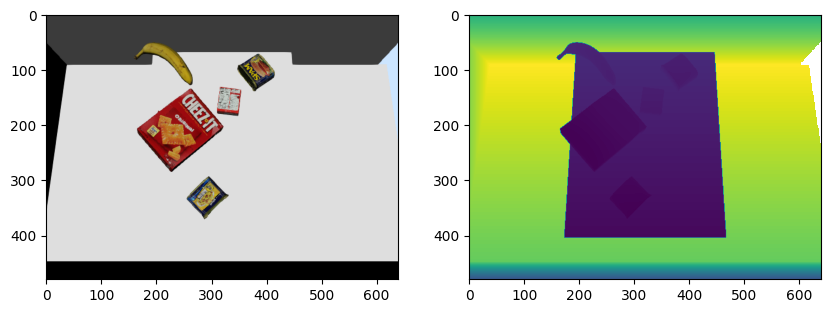

In [47]:
# another way to get the images directly
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera0.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d6be65c-ca3c-46d4-a8f3-21f3622a2ace' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>